In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.9.1')
pyro.set_rng_seed(0)
torch.set_default_dtype(torch.float64)
import matplotlib.pyplot as plt

In [3]:
# find gpu if available, and name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# show device info
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda
NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)


def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 5.5)

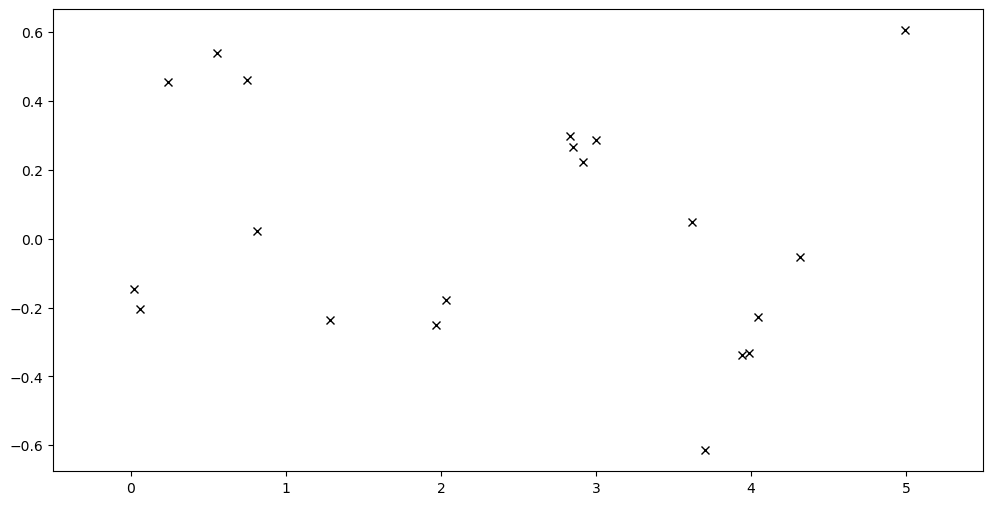

In [11]:
N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3 * X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

plot(plot_observed_data=True)  # let's plot the observed data

In [5]:
"""
gpflow implementation

with gpflow.defer_build():
            ornstein_kernel = gpflow.kernels.Matern12(input_dim = 1)
            regression_model = gpflow.models.GPR(times, trace_around_mean, kern=ornstein_kernel)
            regression_model.kern.lengthscales.prior = gpflow.priors.Uniform(1e-2, 10000)
        regression_model.compile()
        gpflow.train.ScipyOptimizer().minimize(regression_model)
        regression_values = regression_model.kern.read_values()
        this_lengthscale = regression_values['GPR/kern/lengthscales']
"""

# pyro implementation
import numpy as np
import pyro.contrib.gp as gp
from pyro.contrib.gp.kernels.isotropic import Isotropy

from torch.distributions import constraints, transform_to

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp

class Matern12(Isotropy):
    def __init__(self, input_dim, variance=None, lengthscale=None, active_dims=None):
        super().__init__(input_dim, variance, lengthscale, active_dims)

    def forward(self, X, Z=None, diag=False):
        if diag:
            return self._diag(X)

        r = self._scaled_dist(X, Z)
        return self.variance * torch.exp(-r)
    
def measure_fluctuation_rate_of_single_trace(X: np.ndarray, y: np.ndarray) -> float:
    """
    Calculates the fluctuation rate of a trace. Fits an Ornstein-Uhlenbeck process to a
    time-series and estimates the lengthscale parameter, alpha. Specifically alpha = 1/rho.

    Uses Matern 1/2 kernel for the GP model.

    :param np.ndarray trace: The trace to calculate the fluctuation rate of.
    :return float: The fluctuation rate of the trace.
    """

    times = X
    trace_around_mean = y - np.mean(y)

    # set to torch tensor
    times = torch.tensor(times)
    trace_around_mean = torch.tensor(trace_around_mean)

    # setup kernel
    ornstein_kernel = Matern12(1)
    regression_model = gp.models.GPRegression(X = times, y = trace_around_mean, kernel = ornstein_kernel)

    print(ornstein_kernel)

    def update_posterior(x_new):
        y = trace_around_mean[x_new]  # use the value of trace_around_mean at index x_new
        X = torch.cat([regression_model.X, x_new]) # incorporate new evaluation
        y = torch.cat([regression_model.y, y])
        regression_model.set_data(X, y)
        # optimize the GP hyperparameters using Adam with lr=0.001
        optimizer = torch.optim.Adam(regression_model.parameters(), lr=0.001)
        gp.util.train(regression_model, optimizer)

    def lower_confidence_bound(x, kappa=2):
        mu, variance = regression_model(x, full_cov=False, noiseless=False)
        sigma = variance.sqrt()
        return mu - kappa * sigma

    def find_a_candidate(x_init, lower_bound=0, upper_bound=1):
        # transform x to an unconstrained domain
        constraint = constraints.interval(lower_bound, upper_bound)
        unconstrained_x_init = transform_to(constraint).inv(x_init)
        unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
        minimizer = optim.LBFGS([unconstrained_x], line_search_fn='strong_wolfe')

        def closure():
            minimizer.zero_grad()
            x = transform_to(constraint)(unconstrained_x)
            y = lower_confidence_bound(x)
            autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
            return y

        minimizer.step(closure)
        # after finding a candidate in the unconstrained domain,
        # convert it back to original domain.
        x = transform_to(constraint)(unconstrained_x)
        return x.detach()
    
    def next_x(lower_bound=0, upper_bound=1, num_candidates=5):
        candidates = []
        values = []

        x_init = regression_model.X[-1:]
        for i in range(num_candidates):
            x = find_a_candidate(x_init, lower_bound, upper_bound)
            y = lower_confidence_bound(x)
            candidates.append(x)
            values.append(y)
            x_init = x.new_empty(1).uniform_(lower_bound, upper_bound)

        argmin = torch.min(torch.cat(values), dim=0)[1].item()
        return candidates[argmin]
    
    def plot(gs, xmin, xlabel=None, with_title=True):
        xlabel = "xmin" if xlabel is None else "x{}".format(xlabel)
        Xnew = torch.linspace(-0.1, 1.1, 100)
        ax1 = plt.subplot(gs[0])
        ax1.plot(regression_model.X.numpy(), regression_model.y.numpy(), "kx")  # plot all observed data
        with torch.no_grad():
            loc, var = regression_model(Xnew, full_cov=False, noiseless=False)
            sd = var.sqrt()
            ax1.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot predictive mean
            ax1.fill_between(Xnew.numpy(), loc.numpy() - 2*sd.numpy(), loc.numpy() + 2*sd.numpy(),
                            color="C0", alpha=0.3)  # plot uncertainty intervals
        ax1.set_xlim(-0.1, 1.1)
        ax1.set_title("Find {}".format(xlabel))
        if with_title:
            ax1.set_ylabel("Gaussian Process Regression")

        ax2 = plt.subplot(gs[1])
        with torch.no_grad():
            # plot the acquisition function
            ax2.plot(Xnew.numpy(), lower_confidence_bound(Xnew).numpy())
            # plot the new candidate point
            ax2.plot(xmin.numpy(), lower_confidence_bound(xmin).numpy(), "^", markersize=10,
                    label="{} = {:.5f}".format(xlabel, xmin.item()))
        ax2.set_xlim(-0.1, 1.1)
        if with_title:
            ax2.set_ylabel("Acquisition Function")
        ax2.legend(loc=1)

    plt.figure(figsize=(12, 30))
    outer_gs = gridspec.GridSpec(5, 2)
    optimizer = torch.optim.Adam(regression_model.parameters(), lr=0.001)
    gp.util.train(regression_model, optimizer)
    for i in range(8):
        xmin = next_x()
        gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i])
        plot(gs, xmin, xlabel=i+1, with_title=(i % 2 == 0))
        update_posterior(xmin)
    plt.show()
            

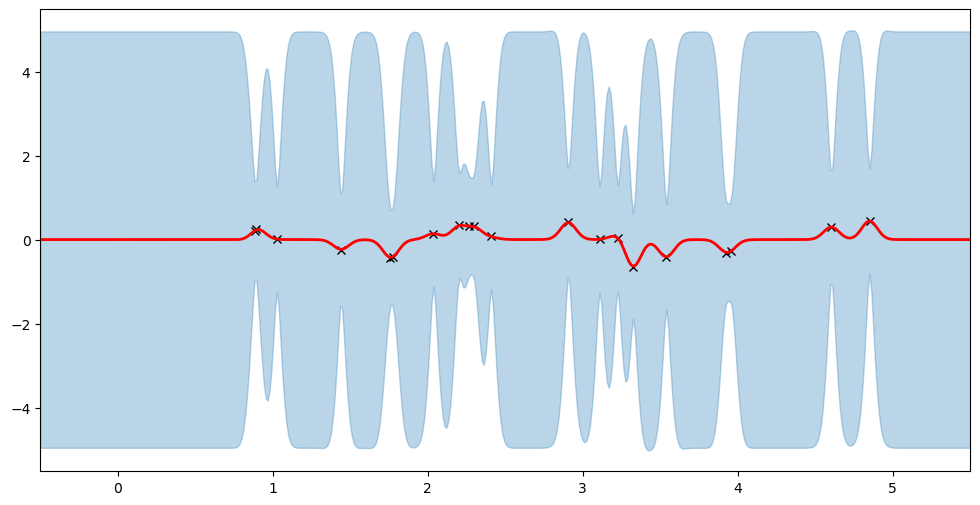

In [14]:
import pyro.distributions as dist
pyro.set_rng_seed(0)
smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo

N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3 * X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.2))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variances = []
lengthscales = []
noises = []
num_steps = 2000 if not smoke_test else 2
for i in range(num_steps):
    variances.append(gpr.kernel.variance.item())
    noises.append(gpr.noise.item())
    lengthscales.append(gpr.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot(model=gpr, plot_observed_data=True, plot_predictions=True)

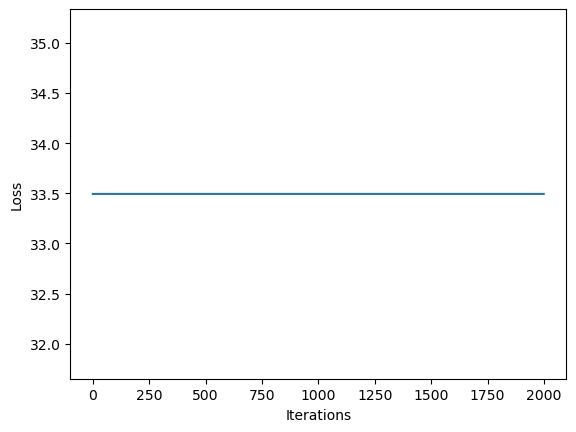

In [15]:
# let's plot the loss curve after 2000 steps of training
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


plot_loss(losses)

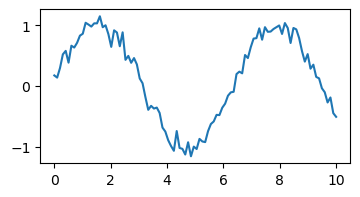

In [7]:
# create sample trace and plot
from numpy import size


N = 100
X = np.linspace(0, 10, N)
y = np.zeros((N, 2))
y = np.sin(X) + np.random.normal(0, 0.1, N)

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(X, y)

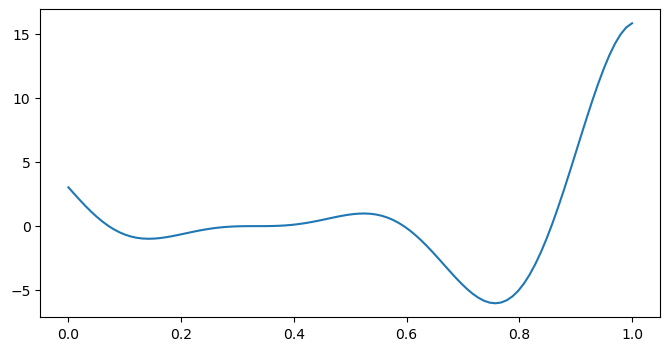

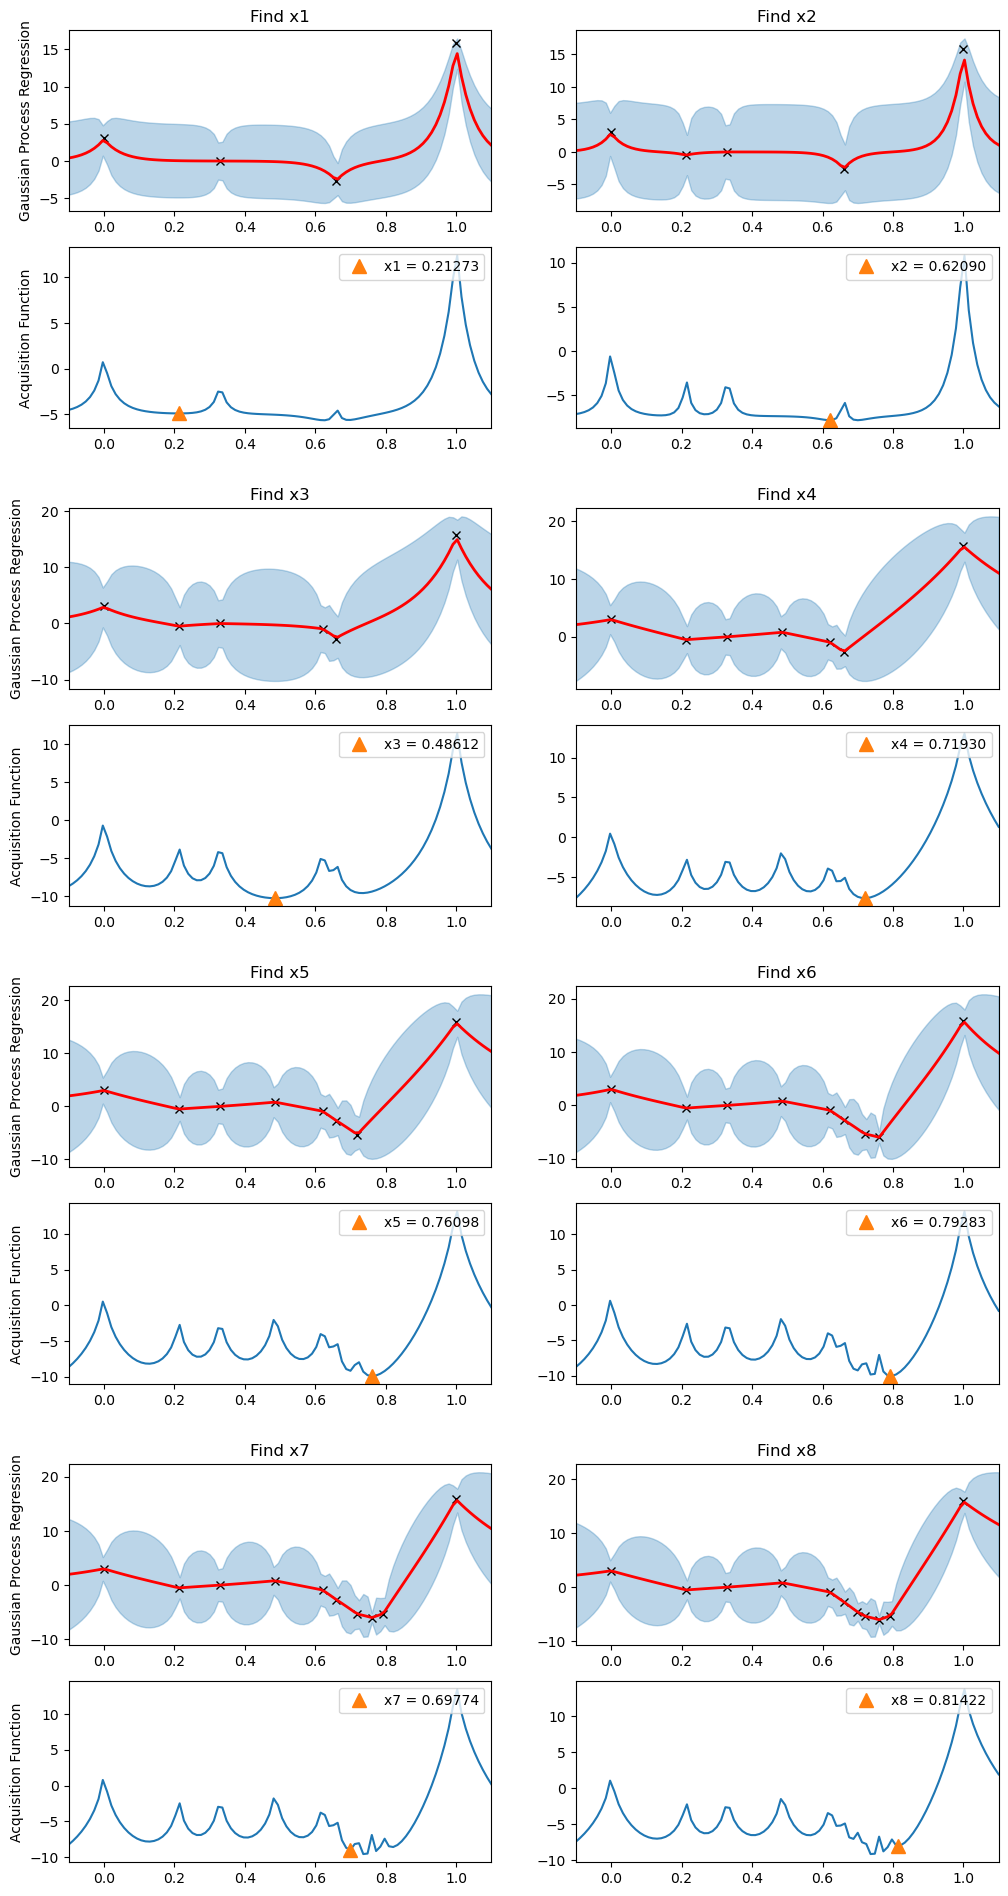

In [8]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp

assert pyro.__version__.startswith('1.9.1')
pyro.set_rng_seed(1)

def f(x):
    return (6 * x - 2)**2 * torch.sin(12 * x - 4)

x = torch.linspace(0, 1, 100)
plt.figure(figsize=(8, 4))
plt.plot(x.numpy(), f(x).numpy())
plt.show()

# initialize the model with four input points: 0.0, 0.33, 0.66, 1.0
X = torch.tensor([0.0, 0.33, 0.66, 1.0])
y = f(X)
gpmodel = gp.models.GPRegression(X, y, Matern12(1),
                                 noise=torch.tensor(0.1), jitter=1.0e-4)

def update_posterior(x_new):
    y = f(x_new) # evaluate f at new point.
    X = torch.cat([gpmodel.X, x_new]) # incorporate new evaluation
    y = torch.cat([gpmodel.y, y])
    gpmodel.set_data(X, y)
    # optimize the GP hyperparameters using Adam with lr=0.001
    optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    gp.util.train(gpmodel, optimizer)

def lower_confidence_bound(x, kappa=2):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    return mu - kappa * sigma

def find_a_candidate(x_init, lower_bound=0, upper_bound=1):
    # transform x to an unconstrained domain
    constraint = constraints.interval(lower_bound, upper_bound)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    minimizer = optim.LBFGS([unconstrained_x], line_search_fn='strong_wolfe')

    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        y = lower_confidence_bound(x)
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        return y

    minimizer.step(closure)
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x = transform_to(constraint)(unconstrained_x)
    return x.detach()

def next_x(lower_bound=0, upper_bound=1, num_candidates=5):
    candidates = []
    values = []

    x_init = gpmodel.X[-1:]
    for i in range(num_candidates):
        x = find_a_candidate(x_init, lower_bound, upper_bound)
        y = lower_confidence_bound(x)
        candidates.append(x)
        values.append(y)
        x_init = x.new_empty(1).uniform_(lower_bound, upper_bound)

    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    return candidates[argmin]

def plot(gs, xmin, xlabel=None, with_title=True):
    xlabel = "xmin" if xlabel is None else "x{}".format(xlabel)
    Xnew = torch.linspace(-0.1, 1.1, 100)
    ax1 = plt.subplot(gs[0])
    ax1.plot(gpmodel.X.numpy(), gpmodel.y.numpy(), "kx")  # plot all observed data
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        ax1.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot predictive mean
        ax1.fill_between(Xnew.numpy(), loc.numpy() - 2*sd.numpy(), loc.numpy() + 2*sd.numpy(),
                         color="C0", alpha=0.3)  # plot uncertainty intervals
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_title("Find {}".format(xlabel))
    if with_title:
        ax1.set_ylabel("Gaussian Process Regression")

    ax2 = plt.subplot(gs[1])
    with torch.no_grad():
        # plot the acquisition function
        ax2.plot(Xnew.numpy(), lower_confidence_bound(Xnew).numpy())
        # plot the new candidate point
        ax2.plot(xmin.numpy(), lower_confidence_bound(xmin).numpy(), "^", markersize=10,
                 label="{} = {:.5f}".format(xlabel, xmin.item()))
    ax2.set_xlim(-0.1, 1.1)
    if with_title:
        ax2.set_ylabel("Acquisition Function")
    ax2.legend(loc=1)

plt.figure(figsize=(12, 30))
outer_gs = gridspec.GridSpec(5, 2)
optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
gp.util.train(gpmodel, optimizer)
for i in range(8):
    xmin = next_x()
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i])
    plot(gs, xmin, xlabel=i+1, with_title=(i % 2 == 0))
    update_posterior(xmin)
plt.show()